### reference
 - https://publikationen.bibliothek.kit.edu/1000129520
 - https://github.com/2Obe/BSData
 - https://www.sciencedirect.com/science/article/pii/S2352340921009185?via%3Dihub

In [109]:
# 基本ライブラリ
import os
import sys
import warnings
import gc
import pickle
import glob
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pathlib
import json
import base64
import io

# ディープラーニング用のライブラリ
import timm
from torch.cuda.amp import autocast, GradScaler
from torch.utils.data import Dataset, DataLoader
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts, OneCycleLR, CosineAnnealingLR, ReduceLROnPlateau, StepLR, LambdaLR
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

# データ前処理、拡張用のライブラリ
from albumentations.pytorch import ToTensorV2
import albumentations as A

# プログレスバーのライブラリ
from tqdm.auto import tqdm
from tqdm.notebook import tqdm
tqdm.pandas()

# 画像処理用のライブラリ
import cv2
import imageio
from PIL import Image, ImageDraw

# アノテーション用のライブラリ
import labelme
from labelme import utils

# セグメンテーション用のライブラリ
import segmentation_models_pytorch as smp

# 評価指標計算用のライブラリ
from sklearn.metrics import accuracy_score, f1_score

# 分割のライブラリ
from sklearn.model_selection import train_test_split

# データ分割のライブラリ
from sklearn.model_selection import StratifiedKFold

# warning設定
import sklearn.exceptions
warnings.filterwarnings("ignore")

In [110]:
# seedの固定
def seed_everything(seed=42):
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic =True
    torch.backends.cudnn.benchmark = False

seed_everything()

# デバイスの設定
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

print(f'Using device: {device}')

Using device: cuda


In [111]:
# 画像のパスを取得
train_path = '/workdir/practical-mi-guide/chapter3/input/10.35097-1278/10.35097-1278/data/dataset/BSData-main/BSData-main/data'
train_files = sorted(glob.glob(os.path.join(train_path, '*.jpg')))
print(f'Train data: {len(train_files)}')

Train data: 1104


In [112]:
# アノテーションのパスを取得
train_label_path = '/workdir/practical-mi-guide/chapter3/input/10.35097-1278/10.35097-1278/data/dataset/BSData-main/BSData-main/label'
train_labels = sorted(glob.glob(os.path.join(train_label_path, '*.json')))
print(f'Train label: {len(train_labels)}')

Train label: 394


In [113]:
# train_filesのうち.jpgを除いた部分がtrain_labelsのうち.jsonを除いた部分と一致するもののみを取得
train_files = [f for f in train_files if os.path.splitext(os.path.basename(f))[0] in [os.path.splitext(os.path.basename(l))[0] for l in train_labels]]
print(f'Train data: {len(train_files)}')

Train data: 394


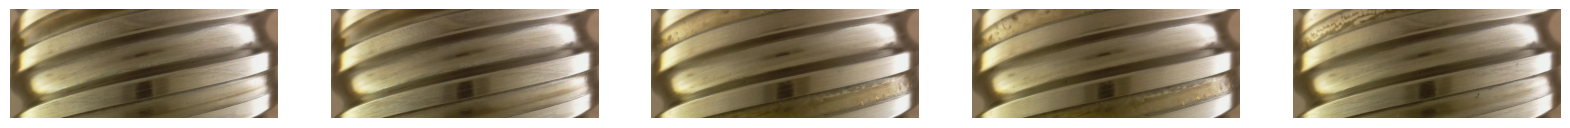

In [114]:
# train_filesの画像を表示
plt.figure(figsize=(20, 10))
for i in range(5):
    plt.subplot(1, 5, i+1)
    img = cv2.imread(train_files[i])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img)
    plt.axis('off')
plt.show()

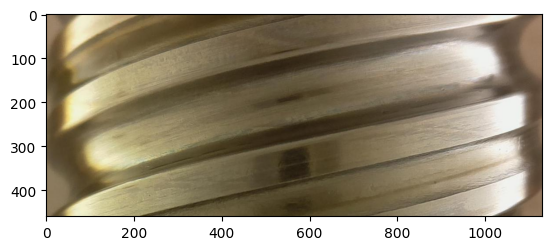

In [115]:
# reference:https://tanalib.com/labelme-json2image/

# jsonデータの読み込み
json_file = open(train_labels[0])
json_data = json.load(json_file)

# imageDataをkeyにしてデータを取り出す
img_b64 = json_data['imageData']

# labelmeのutils関数を使ってbase64形式をPIL型に変換する
img_data = base64.b64decode(img_b64)
img_pil = utils.img_data_to_pil(img_data)

# 画像の可視化
plt.imshow(img_pil)
plt.show()

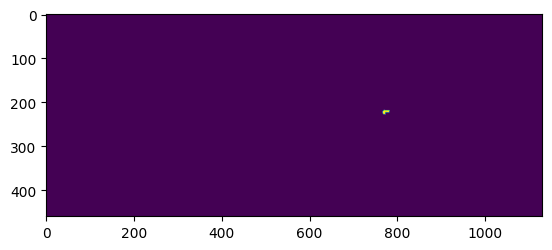

In [116]:
# reference:https://tanalib.com/labelme-json2image/

# アノテーションの頂点座標を取得
points = json_data['shapes'][0]['points'] # 今回は画像中に1つだけ物体があることを想定
# list -> tuple
points = [tuple(point) for point in points]

# マスク画像を生成
w, h = img_pil.size
mask = Image.new('L', (w, h))
draw = ImageDraw.Draw(mask)
draw.polygon(points, fill = 1)

# 画像の可視化
plt.imshow(mask)
plt.show()

In [117]:
# 上記をもとにして、画像とマスクを生成する関数を作成、画像中に複数の物体がある場合も考慮する
def create_mask_from_json(json_data, img_pil):
    # 画像サイズを取得
    w, h = img_pil.size
    # マスク画像を生成
    mask = Image.new('L', (w, h))
    draw = ImageDraw.Draw(mask)
    # マスク画像を生成するためのリスト
    mask_list = []
    # マスク画像を生成
    for shape in json_data['shapes']:
        points = shape['points']
        points = [tuple(point) for point in points]
        mask = Image.new('L', (w, h))
        draw = ImageDraw.Draw(mask)
        draw.polygon(points, fill = 1)
        mask_list.append(mask)
    return mask_list

In [118]:
# train_labelsに対して上記の関数を適用
mask_list = []
train_list = []

for label in train_labels:
    json_file = open(label)
    json_data = json.load(json_file)
    img_b64 = json_data['imageData']

    # labelmeのutils関数を使ってbase64形式をPIL型に変換する
    img_data = base64.b64decode(img_b64)
    img_pil = utils.img_data_to_pil(img_data)
    train_list.append(img_pil)
    mask_list.append(create_mask_from_json(json_data, img_pil))

In [119]:
mask_list

[[<PIL.Image.Image image mode=L size=1130x460>],
 [<PIL.Image.Image image mode=L size=1130x460>],
 [<PIL.Image.Image image mode=L size=1130x460>],
 [<PIL.Image.Image image mode=L size=1130x460>],
 [<PIL.Image.Image image mode=L size=1130x460>],
 [<PIL.Image.Image image mode=L size=1130x460>],
 [<PIL.Image.Image image mode=L size=1130x460>],
 [<PIL.Image.Image image mode=L size=1130x460>],
 [<PIL.Image.Image image mode=L size=1130x460>],
 [<PIL.Image.Image image mode=L size=1130x460>],
 [<PIL.Image.Image image mode=L size=1130x460>],
 [<PIL.Image.Image image mode=L size=1130x460>],
 [<PIL.Image.Image image mode=L size=1130x460>],
 [<PIL.Image.Image image mode=L size=1130x460>],
 [<PIL.Image.Image image mode=L size=1130x460>],
 [<PIL.Image.Image image mode=L size=1130x460>],
 [<PIL.Image.Image image mode=L size=1130x460>],
 [<PIL.Image.Image image mode=L size=1130x460>],
 [<PIL.Image.Image image mode=L size=1130x460>],
 [<PIL.Image.Image image mode=L size=1130x460>],
 [<PIL.Image.Image i

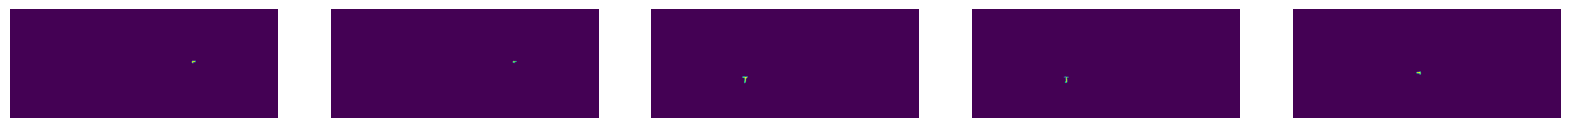

In [120]:
# mask_listの中身を表示
plt.figure(figsize=(20, 10))
for i in range(5):
    plt.subplot(1, 5, i+1)
    plt.imshow(mask_list[i][0])
    plt.axis('off')
plt.show()

In [121]:
train_list

[<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1130x460>,
 <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1130x460>,
 <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1130x460>,
 <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1130x460>,
 <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1130x460>,
 <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1130x460>,
 <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1130x460>,
 <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1130x460>,
 <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1130x460>,
 <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1130x460>,
 <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1130x460>,
 <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1130x460>,
 <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1130x460>,
 <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1130x460>,
 <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1130x4

In [122]:
len(train_list)

394

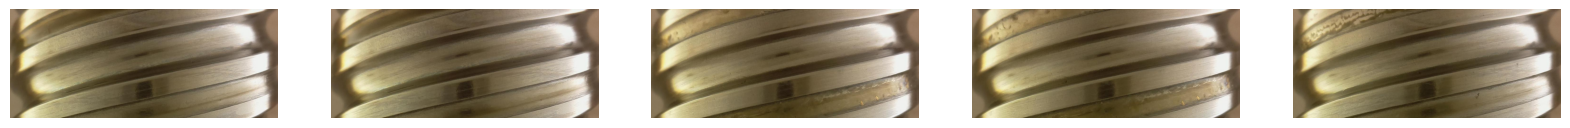

In [123]:
# train_listの中身を表示
plt.figure(figsize=(20, 10))
for i in range(5):
    plt.subplot(1, 5, i+1)
    plt.imshow(train_list[i])
    plt.axis('off')
plt.show()

In [124]:
# train_list[0]のshapeを確認
train_list[0].size

(1130, 460)

In [125]:
# mask_list[0]のshapeを確認
mask_list[0][0].size

(1130, 460)

In [126]:
# train_listとmask_listを使用してsegmentation_models_pytorchを使用してセグメンテーションを行う
# データセットクラスを作成
class SegmentationDataset(Dataset):
    def __init__(self, img_list, mask_list, transform=None):
        self.img_list = img_list
        self.mask_list = mask_list
        self.transform = transform

    def __len__(self):
        return len(self.img_list)

    def __getitem__(self, idx):
        img = self.img_list[idx]
        mask = self.mask_list[idx][0]
        if self.transform:
            transformed = self.transform(image=np.array(img), mask=np.array(mask))
            img = transformed['image']
            mask = transformed['mask']
        return img, mask

# データセットを学習用とテスト用に分割
train_img_list, val_img_list, train_mask_list, val_mask_list = train_test_split(train_list, mask_list, test_size=0.2, random_state=42)

# 画像とマスクの前処理を定義、正規化はA.Normalize()を使用
train_transform = A.Compose([
    A.Resize(256, 256),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.RandomRotate90(p=0.5),
    A.ShiftScaleRotate(p=0.5),
    A.RandomResizedCrop(256, 256, scale=(0.8, 1.0)),
    A.Normalize(),
    ToTensorV2()
])

val_transform = A.Compose([
    A.Resize(256, 256),
    A.Normalize(),
    ToTensorV2()
])

# データセットを作成
train_dataset = SegmentationDataset(train_img_list, train_mask_list, transform=train_transform)
val_dataset = SegmentationDataset(val_img_list, val_mask_list, transform=val_transform)

# データセットをDataLoaderに変換
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False)

# モデルを定義
model = smp.Unet('resnet18', encoder_weights='imagenet', in_channels=3, classes=1).to(device)

# 損失関数を定義
criterion = nn.BCEWithLogitsLoss()

# 最適化手法を定義
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# 学習率スケジューラを定義
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3, verbose=True, eps=1e-6)


In [128]:
len(train_dataset)

315

In [127]:
len(valid_dataset)

79

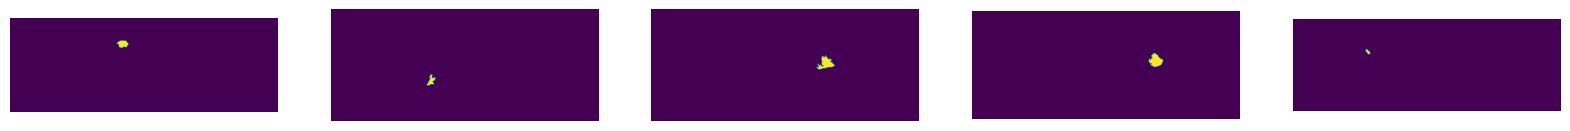

In [160]:
# train_mask_listのマスクを5枚表示
plt.figure(figsize=(20, 10))
for i in range(5):
    plt.subplot(1, 5, i+1)
    img = train_img_list[i]
    mask = train_mask_list[i][0]
    # plt.imshow(img)
    plt.imshow(mask)
    plt.axis('off')
plt.show()

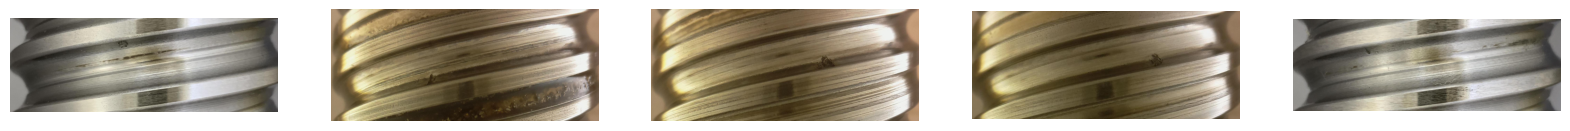

In [162]:
# train_img_listの画像を5枚表示
plt.figure(figsize=(20, 10))
for i in range(5):
    plt.subplot(1, 5, i+1)
    img = train_img_list[i]
    mask = train_mask_list[i][0]
    plt.imshow(img)
    # plt.imshow(mask)
    plt.axis('off')
plt.show()

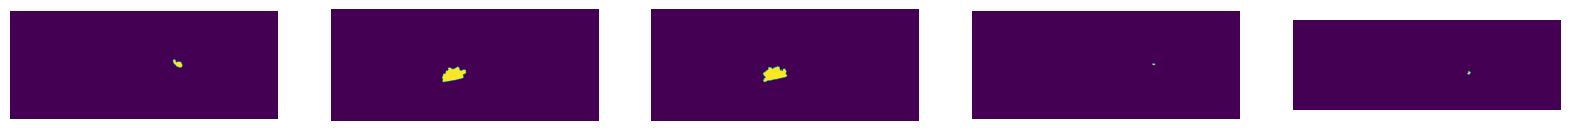

In [133]:
# val_mask_listのマスクを5枚表示
plt.figure(figsize=(20, 10))
for i in range(5):
    plt.subplot(1, 5, i+1)
    img = val_img_list[i]
    mask = val_mask_list[i][0]
    # plt.imshow(img)
    plt.imshow(mask)
    plt.axis('off')
plt.show()

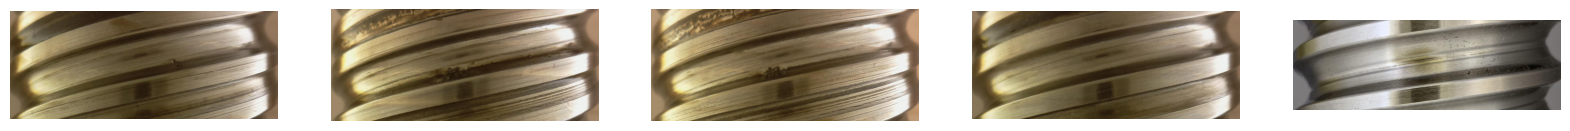

In [134]:
# val_img_listの画像を5枚表示
plt.figure(figsize=(20, 10))
for i in range(5):
    plt.subplot(1, 5, i+1)
    img = val_img_list[i]
    mask = val_mask_list[i][0]
    plt.imshow(img)
    # plt.imshow(mask)
    plt.axis('off')
plt.show()

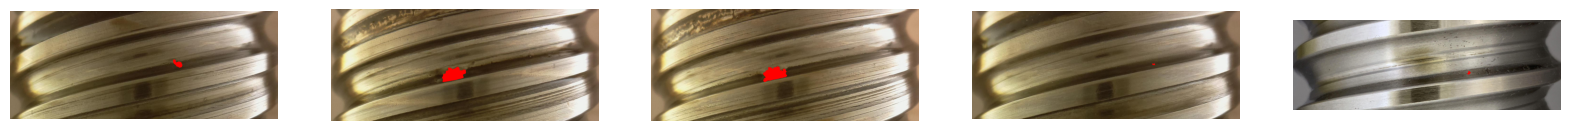

In [135]:
# val_img_list, val_mask_listの画像とマスクを重ねて5枚表示
plt.figure(figsize=(20, 10))
for i in range(5):
    plt.subplot(1, 5, i+1)
    img = val_img_list[i]
    mask = val_mask_list[i][0]
    img = np.array(img)
    mask = np.array(mask)
    img[mask == 1] = [255, 0, 0]
    plt.imshow(img)
    plt.axis('off')
plt.show()

In [146]:
# テストデータは使用せずに学習
num_epochs = 30
scaler = GradScaler()

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for inputs, masks in tqdm(train_loader):
        inputs = inputs.to(device)
        masks = masks.to(device)
        optimizer.zero_grad()
        with autocast():
            outputs = model(inputs)
            # ターゲットの形状を [バッチサイズ, 高さ, 幅] から [バッチサイズ, チャンネル数, 高さ, 幅] に変更する
            masks = masks.unsqueeze(1).type(torch.float32)  # 1チャンネル目に次元を追加、BCEWithLogitsLoss はFloat型のターゲットを期待する
            loss = criterion(outputs, masks)
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        running_loss += loss.item()
    train_loss = running_loss / len(train_loader)
    print(f'Epoch: {epoch+1}/{num_epochs}, Loss: {train_loss}')

    model.eval()
    running_loss = 0.0
    for inputs, masks in tqdm(val_loader):
        inputs = inputs.to(device)
        masks = masks.to(device)
        with torch.no_grad():
            outputs = model(inputs)
            masks = masks.unsqueeze(1).type(torch.float32)
            loss = criterion(outputs, masks)
        running_loss += loss.item()
    val_loss = running_loss / len(val_loader)
    print(f'Epoch: {epoch+1}/{num_epochs}, Loss: {val_loss}')
    scheduler.step(val_loss)

  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 1/30, Loss: 0.757306045293808


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1/30, Loss: 0.5587138175964356


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 2/30, Loss: 0.5331162080168724


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 2/30, Loss: 0.45562194287776947


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 3/30, Loss: 0.3794470615684986


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 3/30, Loss: 0.33170694708824155


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 4/30, Loss: 0.2956994421780109


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 4/30, Loss: 0.2832626521587372


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 5/30, Loss: 0.24842179156839847


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 5/30, Loss: 0.2289157748222351


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 6/30, Loss: 0.2144220232963562


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 6/30, Loss: 0.19712405651807785


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 7/30, Loss: 0.18741544485092163


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 7/30, Loss: 0.18724240809679032


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 8/30, Loss: 0.16675093695521354


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 8/30, Loss: 0.1608808532357216


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 9/30, Loss: 0.14905271381139756


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 9/30, Loss: 0.14374227821826935


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 10/30, Loss: 0.13189254514873028


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 10/30, Loss: 0.12821547240018843


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 11/30, Loss: 0.11852019764482975


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 11/30, Loss: 0.1123122327029705


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 12/30, Loss: 0.10722405165433883


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 12/30, Loss: 0.10011078640818596


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 13/30, Loss: 0.0979652926325798


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 13/30, Loss: 0.09427644312381744


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 14/30, Loss: 0.08884337525814771


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 14/30, Loss: 0.08486502170562744


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 15/30, Loss: 0.08193144556134939


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 15/30, Loss: 0.0763895109295845


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 16/30, Loss: 0.0752389557659626


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 16/30, Loss: 0.07060264050960541


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 17/30, Loss: 0.07077080719172954


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 17/30, Loss: 0.08965579345822335


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 18/30, Loss: 0.06633879020810127


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 18/30, Loss: 0.06318517923355102


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 19/30, Loss: 0.06049741134047508


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 19/30, Loss: 0.0560799140483141


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 20/30, Loss: 0.056238761730492116


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 20/30, Loss: 0.05309713669121265


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 21/30, Loss: 0.05211860937997699


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 21/30, Loss: 0.04989869818091393


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 22/30, Loss: 0.04860851056873798


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 22/30, Loss: 0.05109230764210224


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 23/30, Loss: 0.045344415865838525


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 23/30, Loss: 0.04190834201872349


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 24/30, Loss: 0.04243438122794032


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 24/30, Loss: 0.04118700996041298


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 25/30, Loss: 0.03955197464674711


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 25/30, Loss: 0.036878707259893416


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 26/30, Loss: 0.03696437990292907


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 26/30, Loss: 0.03436299562454224


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 27/30, Loss: 0.034599222056567666


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 27/30, Loss: 0.03200628906488419


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 28/30, Loss: 0.032581309555098414


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 28/30, Loss: 0.030609096214175225


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 29/30, Loss: 0.03063316340558231


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 29/30, Loss: 0.029104464687407017


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 30/30, Loss: 0.028674351144582035


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 30/30, Loss: 0.026776167191565038


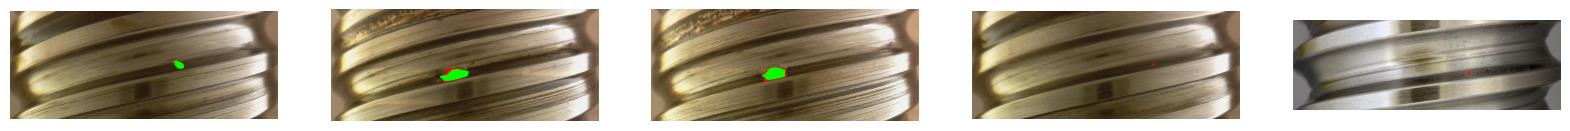

In [154]:
plt.figure(figsize=(20, 10))
for i in range(5):
    plt.subplot(1, 5, i+1)
    img = val_img_list[i]
    mask = val_mask_list[i][0]
    img = np.array(img)
    mask = np.array(mask)
    img[mask == 1] = [255, 0, 0]
    pred = outputs[i].squeeze().cpu().numpy()  # モデルからの予測結果を取得

    # predをimgのサイズにリサイズする
    pred_resized = cv2.resize(pred, (img.shape[1], img.shape[0]), interpolation=cv2.INTER_NEAREST)

    # 予測マスクを元の画像に適用
    img[pred_resized > 0.5] = [0, 255, 0]  # 予測された部分を緑色で表示

    plt.imshow(img)
    plt.axis('off')

plt.show()

In [159]:
# 上記5枚のIoUを計算
iou_list = []
for i in range(5):
    mask = val_mask_list[i][0]  # 正解マスクを取得
    if isinstance(mask, Image.Image):
        mask = np.array(mask)  # PIL ImageをNumPy配列に変換
    
    pred = outputs[i].squeeze().cpu().numpy()  # モデルの予測結果をNumPy配列に変換
    
    # モデル出力をリサイズして元のマスクと同じサイズにする
    pred_resized = cv2.resize(pred, (mask.shape[1], mask.shape[0]), interpolation=cv2.INTER_NEAREST)
    
    # リサイズした予測結果をバイナリ化
    pred_mask = np.zeros_like(pred_resized, dtype=np.uint8)
    pred_mask[pred_resized > 0.5] = 1

    # 正解マスクもバイナリ化
    mask_binary = mask
    mask_binary[mask > 0.5] = 1

    # IoUの計算
    intersection = np.sum(mask_binary * pred_mask)
    union = np.sum((mask_binary + pred_mask) > 0)
    iou = intersection / union if union != 0 else 0  # ゼロ割を避ける
    iou_list.append(iou)

print(iou_list)

[0.577639751552795, 0.6920243986649787, 0.7725295965208988, 0.0, 0.0]


In [164]:
# val_dataset全てのIoUを計算
iou_list = []
for i in range(len(val_dataset)):
    img, mask = val_dataset[i]
    img = img.unsqueeze(0).to(device)
    mask = mask.unsqueeze(0).to(device)
    with torch.no_grad():
        output = model(img)
    pred = output.squeeze().cpu().numpy()
    pred_resized = cv2.resize(pred, (mask.size(2), mask.size(1)), interpolation=cv2.INTER_NEAREST)
    pred_mask = np.zeros_like(pred_resized, dtype=np.uint8)
    pred_mask[pred_resized > 0.5] = 1
    mask_binary = mask.squeeze().cpu().numpy()
    mask_binary[mask_binary > 0.5] = 1
    intersection = np.sum(mask_binary * pred_mask)
    union = np.sum((mask_binary + pred_mask) > 0)
    iou = intersection / union if union != 0 else 0
    iou_list.append(iou)
    
print(np.mean(iou_list))

0.444301281362821


In [166]:
iou_list

[0.6715328467153284,
 0.7014134275618374,
 0.7554744525547445,
 0.0,
 0.0,
 0.7913978494623656,
 0.0,
 0.7861635220125787,
 0.7982456140350878,
 0.7634069400630915,
 0.0,
 0.7507598784194529,
 0.5538461538461539,
 0.6291390728476821,
 0.21052631578947367,
 0.7833827893175074,
 0.611353711790393,
 0.4340175953079179,
 0.7021996615905245,
 0.22857142857142856,
 0.0,
 0.0,
 0.0,
 0.0,
 0.4589041095890411,
 0.6521739130434783,
 0.7652439024390244,
 0.0,
 0.6944444444444444,
 0.8435517970401691,
 0.7372262773722628,
 0.0,
 0.7654784240150094,
 0.0,
 0.8248587570621468,
 0.8345021037868162,
 0.6992481203007519,
 0.3142857142857143,
 0.02197802197802198,
 0.40625,
 0.5754716981132075,
 0.7216117216117216,
 0.0,
 0.8085106382978723,
 0.1111111111111111,
 0.7658862876254181,
 0.0,
 0.42021276595744683,
 0.7822966507177034,
 0.5374149659863946,
 0.5421686746987951,
 0.0,
 0.5142857142857142,
 0.4473684210526316,
 0.0,
 0.7787742899850523,
 0.7789934354485777,
 0.5916666666666667,
 0.0,
 0.0,
 0.

In [167]:
len(iou_list)

79